In [1]:
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

In [2]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

In [3]:
N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges, bocquet16=True)

100%|██████████| 4/4 [05:21<00:00, 80.38s/it]


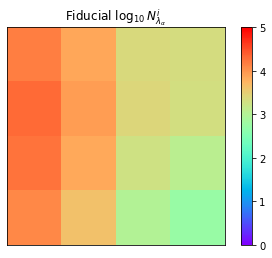

In [4]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(N_fiducial), cmap='rainbow', vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'Fiducial $\log_{10} N^i_{\lambda_\alpha}$')
plt.savefig('fiducial_cluster_abundance_b16.pdf')

In [5]:
cluster_count_cov = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))


In [6]:
halo_bias = ccl.halos.HaloBiasTinker10()

In [7]:
fiducial_h = fiducial_cosmology['H0']/100
halo_bias(fiducial_ccl_cosmo, 1e14 *  fiducial_h, 1) #[Mass] is Msun / h

1.5606575620098777

In [8]:
Ωs_rad**2

30.064534269753832

In [9]:
from classy import Class

h = fiducial_cosmology['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': fiducial_cosmology['ombh2'] / h**2,
    'Omega_cdm': fiducial_cosmology['omch2'] / h**2,
    'N_ur': 0.00641,
    'N_ncdm': 1,
    'output': 'mPk mTk',
    'z_pk': '0.0,99',
    'P_k_max_h/Mpc': 20.,
    'm_ncdm': fiducial_cosmology['nu_mass_ev']/3,
    'deg_ncdm': 3,
    'T_cmb': 2.7255,
    'A_s': fiducial_cosmology['10^9 As'] * 10**-9,
    'n_s': fiducial_cosmology['ns'],
    'Omega_Lambda': 0.0,
    'w0_fld': fiducial_cosmology['w0'],
    'wa_fld': 0.0,
    'cs2_fld': 1.0,
    'fluid_equation_of_state': "CLP"
}

#get logsigma spline
z = np.linspace(0, 2, 100)

pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()

In [10]:
pkclass.pk_lin(1e-1, np.array([0.8]))*h**3 

1406.238361048991

10.0


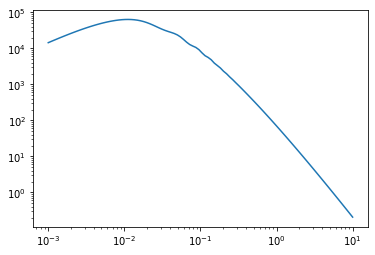

In [11]:
kt = np.logspace(-3, 1, 100)
PK_TEST = [pkclass.pk_lin(k_curr, np.array([0.2])) for k_curr in kt]
plt.plot(kt, PK_TEST)
plt.xscale('log')
plt.yscale('log')
print(np.max(kt))

In [12]:
from scipy.interpolate import InterpolatedUnivariateSpline

def compute_chi_integrand(z_val):
    Ωb =  fiducial_cosmology['ombh2'] / h**2
    Ωc =  fiducial_cosmology['omch2'] / h**2
    Ez = np.sqrt((Ωb+Ωc)*(1+z_val)**3 + (1-(Ωb+Ωc))) # unitless
    return DH/Ez #units of distance h^-1 Mpc
def compute_chi(z_val):
    chi, _ = quad(compute_chi_integrand, 0, z_val, epsabs=0, epsrel=1e-4)#units of h^-1 Mpc
    return chi


z_values = np.linspace(0, 2, 500)  # Create an array of z values (adjust range and number of points as needed)
chi_values = [compute_chi(z) for z in z_values]
chi_spline = InterpolatedUnivariateSpline(z_values, chi_values)

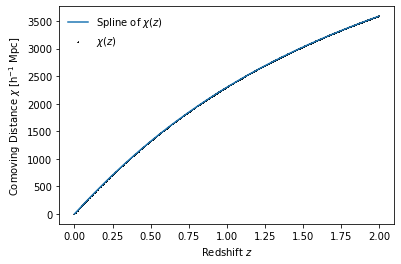

In [13]:
plt.figure()
plt.plot(z_values, chi_spline(z_values), label='Spline of $\\chi(z)$')
plt.scatter(z_values, chi_values, label=r'$\chi(z)$', s=1, marker='+', color='k')
plt.xlabel('Redshift $z$')
plt.ylabel('Comoving Distance $\\chi$ [h$^{-1}$ Mpc]')
plt.legend(frameon=False)
plt.show()


$$\begin{align} 
{\rm Cov} (N^i_{\lambda_\alpha}, N^j_{\lambda_\beta}) &= \delta_{ij} \delta_{\alpha,\beta} N^i_{\lambda_\alpha} + \Omega_s^2 \int_{\textrm{z bin overlap} } dz\ \left( \frac{dV} {dzd\Omega}  \right)^2 \frac{E(z)} {D_H} \\
&\times\left[\int dM \frac{ d n } { d M } b_h(M,z) \int_{\lambda_{\alpha,{\rm min} }}^{\lambda_{\alpha,{\rm max}}} d\lambda\ p(\lambda\mid M,z)\right]\\
&\times\left[\int dM' \frac{ d n } { d M' } b_h(M',z) \int_{\lambda_{\beta,{\rm min} }}^{\lambda_{\beta,{\rm max}}} d\lambda'\ p(\lambda'\mid M',z)\right]\\
&\times \int \frac{d^2 k_\perp}{(2\pi)^2} P_{\rm lin}(k_\perp, z) \left[\frac{ 2 j_1(k_\perp \chi(z) \theta_s)}{k_\perp \chi(z) \theta_s} \right]^2
\end{align} $$
see TakadaSpergel13 Eq (31) and Krause+17 Eq (A15) which I believe is missing $\sigma$ since the units don't work

- $\theta_s=\sqrt{\Omega_s / \pi}$ 
- $j_1$ is a spherical bessel function
- $\chi(z)$ is computed as $$\chi(z) = D_H\int_0^z \frac{dz'}{E(z')}$$

In [14]:
from scipy.integrate import quad, dblquad
from scipy.special import spherical_jn as jn

from functools import cache

θs = np.sqrt(Ωs_rad / np.pi)

    
@cache
def variance_integral(kperp1, kperp2, z_val):
    kperp = np.sqrt(kperp1**2 + kperp2**2) #units of h / Mpc
    #kperp*h has units 1 / Mpc
    Plin = pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3 
    chi = chi_spline(z_val)
    arg = 2*jn(1, kperp*chi*θs) / (kperp*chi*θs) #unitless
    return Plin * arg**2 / (2*np.pi)**2 #units of Mpc^3/h^3 ~ distance^3

@cache
def inner_integral(lam, M, z_val):
    p = cluster_richness_relation(M, lam, z_val)
    
    dn_dM = bocquet16_hmf(fiducial_ccl_cosmo, M/h, redshiftToScale(z_val)) / (h**4 * M * np.log(10))

    bh = halo_bias(fiducial_ccl_cosmo, M * fiducial_h, 1./(1+z_val))
    return p * dn_dM  * bh

    

MAX_K = 10
def outer_integral(z_val, lam_alpha_min, lam_alpha_max, lam_beta_min, lam_beta_max):
    integral_M_val, _ = dblquad(inner_integral, M_min, M_max, lam_alpha_min, lam_alpha_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)

    integral_M_prime_val, _ = dblquad(inner_integral, M_min, M_max, lam_beta_min, lam_beta_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)
    
    d2V_dzdOmega = comoving_volume_elements(z_val, tuple(fiducial_cosmo_vals))
    h = fiducial_cosmology['H0']/100
    Ωb =  fiducial_cosmology['ombh2'] / h**2
    Ωc =  fiducial_cosmology['omch2'] / h**2

    Ez = np.sqrt((Ωb+Ωc)*(1+z_val)**3 + (1-(Ωb+Ωc))) # unitless
    
    variance, _ = dblquad(variance_integral, 0, MAX_K, 0, MAX_K, args=(z_val,), epsrel=1e-4, epsabs=0)

    return Ωs_rad**2 * integral_M_val * integral_M_prime_val * d2V_dzdOmega**2 * Ez/DH * variance







In [15]:
test, _ = quad(outer_integral, 
                         0.2, 0.4, 
                         args=(20, 30, 
                               20, 30),
                        epsrel=1e-4, epsabs=0)
print('%.1e'%(test))

/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


3.4e+02


In [ ]:
all_bin_combos = [[i,j,a,b] for i in range(len(z_bin_edges) - 1) 
 for j in range(len(z_bin_edges) - 1) 
 for a in range(len(richness_bin_edges) - 1)
for b in range(len(richness_bin_edges) - 1)]


for i,j,a,b in tqdm(all_bin_combos):
    zi_min = z_bin_edges[i]
    zi_max = z_bin_edges[i + 1]
    zj_min = z_bin_edges[j]
    zj_max = z_bin_edges[j + 1]
    #from Eq(6) of Krause+17, it seems like supersample variance only
    #when the redshift bins overlap. so we can ignore when
    #zi != zj
    if(i != j):
        continue
    la_min = richness_bin_edges[a]
    la_max = richness_bin_edges[a + 1]
    lb_min = richness_bin_edges[b]
    lb_max = richness_bin_edges[b + 1]
    result, error = quad(outer_integral, 
                         zi_min, zi_max, 
                         args=(la_min, la_max, 
                               lb_min, lb_max),
                        epsrel=1e-4, epsabs=0)
    cluster_count_cov[i,j,a,b] = result 
    if(i == j and a == b): #shot noise
        cluster_count_cov[i,j,a,b] +=  N_fiducial[i][a]


  6%|▋         | 16/256 [02:49<37:18,  9.33s/it] 

In [ ]:
import pickle
    
with open('cluster_abundance_fiducial_covariance_b16.pkl', 'wb') as file:
        pickle.dump(cluster_count_cov, file)

In [ ]:
n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]


In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'

plt.figure( dpi=600)
plt.imshow(np.log10(cov_matrix_2d), cmap='rainbow', aspect=1, vmin=-1, vmax=4.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tick_params(
    bottom=False,
    top=True,
labelbottom=False,
labeltop=True)
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 


# Add ticks for the block divisions
tick_positions_z = np.arange(n_r, n_r * n_z+1, n_r) - 2.5

tick_z_labels = [r'$z^i:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.xticks(tick_positions_z, tick_z_labels, ha='center')

tick_z_labels = [r'$z^j:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.yticks(tick_positions_z, tick_z_labels, rotation=90, va='center')

lambda_labels = [r'$\lambda_\alpha:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]
lambda_labels_0 = [r'$\lambda_\beta:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]

lw=0.5
for i,l in enumerate(lambda_labels):
    plt.text(3.65 , i,
            s=l,
            horizontalalignment='left',
            verticalalignment='center',
           fontsize=8)
    plt.text(i , 3.65,
            s=lambda_labels_0[i],
            horizontalalignment='center',
            verticalalignment='top',
             rotation=90,
           fontsize=8)
    plt.axvline(i+0.5, .5, .75, linewidth=lw, linestyle='-', color='k')
    plt.axhline(i+0.5, 0.25, 0.5, linewidth=lw, linestyle='-', color='k')

    for j in range(n_z):
        plt.axvline(i+0.5+n_z*j, 0.75-0.25*j,1-0.25*j, linewidth=lw, linestyle='--', color='k')
        plt.axhline(i+0.5+n_z*j, 0+0.25*j,0.25+0.25*j, linewidth=lw, linestyle='--', color='k')

for a in tick_positions_z:
    plt.axvline(a+2, color='black', linestyle='-', linewidth=lw)
    plt.axhline(a+2, color='black', linestyle='-', linewidth=lw)

plt.title(r'$\log_{10}{\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$' + '\n')
plt.savefig('cluster_abundance_cov_b16.pdf', dpi=600, bbox_inches = "tight")

In [ ]:
import matplotlib.pyplot as plt


plt.figure( dpi=600)
plt.tick_params(
    bottom=False,
    top=True,
labelbottom=False,
labeltop=True)
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 


# Add ticks for the block divisions
tick_positions_z = [0,1,2,3]

tick_z_labels = [r'$\lambda_\alpha:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]
plt.xticks(tick_positions_z, tick_z_labels, ha='center')

tick_z_labels = [r'$z^j:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.yticks(tick_positions_z, tick_z_labels, rotation=90, va='center')


plt.imshow(np.log10(N_fiducial), cmap='rainbow', vmin=0, vmax=5)
plt.colorbar()
plt.title(r'Fiducial $\log_{10} N^i_{\lambda_\alpha}$'+'\n')
plt.savefig('fiducial_cluster_abundance_b16.pdf', dpi=600, bbox_inches = "tight")

In [ ]:
n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d_shot_noise_only = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                if(i==j and a==b):
                    cov_matrix_2d_shot_noise_only[row_index, col_index] = N_fiducial[i][a]

In [ ]:
all_bin_combos = [[i,j,a,b] for i in range(len(z_bin_edges) - 1) 
 for j in range(len(z_bin_edges) - 1) 
 for a in range(len(richness_bin_edges) - 1)
for b in range(len(richness_bin_edges) - 1)]

cluster_count_cov_shot_only = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))

for i,j,a,b in tqdm(all_bin_combos):
    if(i == j and a == b): #shot noise
        cluster_count_cov_shot_only[i,j,a,b] +=  N_fiducial[i][a]


In [ ]:
import pickle
    
with open('cluster_abundance_fiducial_covariance_shot_noise_only_b16.pkl', 'wb') as file:
        pickle.dump(cluster_count_cov_shot_only, file)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'

plt.figure( dpi=600)
plt.imshow(np.log10(cov_matrix_2d_shot_noise_only), cmap='rainbow', aspect=1, vmin=-1, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tick_params(
    bottom=False,
    top=True,
labelbottom=False,
labeltop=True)
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 


# Add ticks for the block divisions
tick_positions_z = np.arange(n_r, n_r * n_z+1, n_r) - 2.5

tick_z_labels = [r'$z^i:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.xticks(tick_positions_z, tick_z_labels, ha='center')

tick_z_labels = [r'$z^j:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.yticks(tick_positions_z, tick_z_labels, rotation=90, va='center')

lambda_labels = [r'$\lambda_\alpha:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]
lambda_labels_0 = [r'$\lambda_\beta:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]

for i,l in enumerate(lambda_labels):
    plt.text(3.65 , i,
            s=l,
            horizontalalignment='left',
            verticalalignment='center',
           fontsize=6)
    plt.text(i , 3.65,
            s=lambda_labels_0[i],
            horizontalalignment='center',
            verticalalignment='top',
             rotation=90,
           fontsize=6)
    plt.axvline(i+0.5, .75,1, linewidth=0.5, linestyle='--', color='k')
    plt.axhline(i+0.5, 0,0.25, linewidth=0.5, linestyle='--', color='k')

for a in tick_positions_z:
    plt.axvline(a+2, color='black', linestyle='-', linewidth=1)
    plt.axhline(a+2, color='black', linestyle='-', linewidth=1)

plt.title(r'$\log_{10}{\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$ Shot Noise Only' + '\n')


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'

plt.figure( dpi=600)
plt.imshow(np.log10(cov_matrix_2d -cov_matrix_2d_shot_noise_only), cmap='rainbow', aspect=1)#, vmin=-1, vmax=4.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tick_params(
    bottom=False,
    top=True,
labelbottom=False,
labeltop=True)
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 


# Add ticks for the block divisions
tick_positions_z = np.arange(n_r, n_r * n_z+1, n_r) - 2.5

tick_z_labels = [r'$z^i:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.xticks(tick_positions_z, tick_z_labels, ha='center')

tick_z_labels = [r'$z^j:[%.1f, %.1f]$'%(a,b) for a,b in zip(z_bin_edges, z_bin_edges[1:])]
plt.yticks(tick_positions_z, tick_z_labels, rotation=90, va='center')

lambda_labels = [r'$\lambda_\alpha:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]
lambda_labels_0 = [r'$\lambda_\beta:[%d, %d]$'%(a,b) for a,b in zip(richness_bin_edges, richness_bin_edges[1:])]

lw=0.5
for i,l in enumerate(lambda_labels):
    plt.text(3.65 , i,
            s=l,
            horizontalalignment='left',
            verticalalignment='center',
           fontsize=8)
    plt.text(i , 3.65,
            s=lambda_labels_0[i],
            horizontalalignment='center',
            verticalalignment='top',
             rotation=90,
           fontsize=8)
    plt.axvline(i+0.5, .5, .75, linewidth=lw, linestyle='-', color='k')
    plt.axhline(i+0.5, 0.25, 0.5, linewidth=lw, linestyle='-', color='k')

    for j in range(n_z):
        plt.axvline(i+0.5+n_z*j, 0.75-0.25*j,1-0.25*j, linewidth=lw, linestyle='--', color='k')
        plt.axhline(i+0.5+n_z*j, 0+0.25*j,0.25+0.25*j, linewidth=lw, linestyle='--', color='k')

for a in tick_positions_z:
    plt.axvline(a+2, color='black', linestyle='-', linewidth=lw)
    plt.axhline(a+2, color='black', linestyle='-', linewidth=lw)

plt.title(r'$\log_{10}{\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$' + '\n')
